# Training

In [7]:
import pandas as pd

train_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/train_set_full.csv"
)
train_set = pd.read_csv(train_set_path)
print(f"train set count: {train_set.shape[0]:,}")
train_set.head(3)

train set count: 67,342


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.11025,-0.007737,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
1,-0.11025,-0.007723,-0.002891,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432
2,-0.11025,-0.007728,-0.004814,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,...,-0.31289,-0.11205,-0.028606,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432


# Perform PCA

In [8]:
from sklearn.decomposition import PCA

# Initialize PCA with 99998% variance retention
pca = PCA(n_components=0.99998)

# Fit PCA on the training data and transform it
train_set_pca = pca.fit_transform(train_set)

# Print the number of components and explained variance ratio
print(f"Number of components selected: {pca.n_components_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

Number of components selected: 69
Total variance explained: 1.0000


# Training

In [ ]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(kernel="rbf", gamma="auto", nu=0.2, verbose=True)
ocsvm.fit(train_set_pca)

[LibSVM]

# Testing

Preparing test set

In [ ]:
test_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/test_set.csv"
)

test_set = pd.read_csv(test_set_path)
print(f"test set count: {test_set.shape[0]:,}")
test_set.head(3)

test set count: 22,543


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
0,-0.110250,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,-1.211893,-0.046432,-1,neptune,DoS
1,-0.109482,-0.005551,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,1,normal,normal
2,-0.110250,-0.007759,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,...,-0.139983,-0.618441,-0.053906,-0.031768,-0.019726,0.825156,-0.046432,-1,saint,Probe


In [ ]:
X_test = test_set.drop(columns=["attack_binary", "attack_categorical", "attack_class"])

y_test = test_set["attack_binary"]
print(y_test.unique())

[-1  1]


In [ ]:
# Transform test data using the same PCA model
X_test_pca = pca.transform(X_test)

Perform prediction

In [ ]:
y_pred = ocsvm.predict(X_test_pca)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[10254  2578]
 [ 3404  6307]]


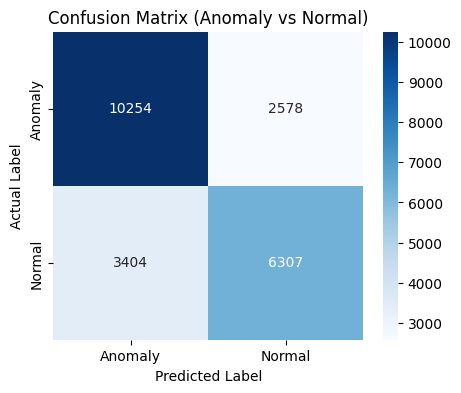

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [ ]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Anomaly", "Normal"]))

precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.75      0.80      0.77     12832
      Normal       0.71      0.65      0.68      9711

    accuracy                           0.73     22543
   macro avg       0.73      0.72      0.73     22543
weighted avg       0.73      0.73      0.73     22543

Precision: 0.7507687802020794
Recall: 0.7990960099750624
F1 Score: 0.7741789354473386
